We will follow a two step process for classifying the EEG data. First, we will load the data set and extract features. Then we will run several models on the resulting data.

In [1]:
import numpy as np
import pandas as pd
import tsfresh as ts

In [8]:
original_path = "./data/seizures_original.csv"
rawData = pd.read_csv(original_path).loc[:,"X1":"X178"]
TimeStamps = [round(1000*t/178,2) for t in range(1,179)]*len(pd.read_csv(original_path)[["X1"]])
rawData = rawData.transpose().melt()

In [3]:
#rawData[["time"]] = pd.DataFrame(TimeStamps,columns=["time"])
rawData["time"] = pd.Series(TimeStamps)

In [4]:
response = pd.read_csv(path).loc[:,"y"]
y = []
for i in range(len(response)):
    y.extend([str(response[i])]*178)
y = y
rawData["y"] = pd.Series(y)
y = pd.Series(y)
response = pd.Series(response)

In [5]:
from tsfresh import extract_relevant_features
rfd = extract_relevant_features(rawData.loc[:,"variable":"time"], 
                                response, 
                                column_id='variable', 
                                column_sort='time',
                                column_value="value",
                                ml_task="classification")

Feature Extraction: 100%|██████████| 20/20 [05:42<00:00, 17.13s/it]


In [6]:
write_path = "./data/seizures_features.csv"
rfd.to_csv(write_path)

In [9]:
features_path = "./data/seizures_features.csv"
original_path = "./data/seizures_original.csv"
rfd_read = pd.read_csv(features_path)
response = pd.read_csv(original_path).loc[:,"y"]

In [11]:
from tsfresh.feature_selection.relevance import calculate_relevance_table
full_rel_table = calculate_relevance_table(rfd,response,
                                           ml_task='classification')

Next, we run several models.

In [12]:
from sklearn.model_selection import train_test_split as split
X = rfd
y = response
X_train, X_test, y_train, y_test = split(X,y,test_size=round(11500*0.2),random_state=145)

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score
def accuracy_score(CM):
    return round(np.sum(np.diag(CM))/np.sum(CM),4)*100

# Support Vector Machine

In [17]:
from sklearn.svm import SVC
SVM1_clf = SVC(gamma="scale", random_state=42)
rdf_SVM1 = SVM1_clf.fit(X_train,y_train)
y_pred_SVM1 = rdf_SVM1.predict(X_test)
CM_SVM1 = confusion_matrix(y_test,y_pred_SVM1)

In [15]:
print(classification_report(y_test,y_pred_SVM1))

              precision    recall  f1-score   support

           1       0.91      0.90      0.90       460
           2       0.80      0.03      0.05       457
           3       0.23      0.07      0.10       457
           4       0.39      0.11      0.17       469
           5       0.28      0.97      0.44       457

    accuracy                           0.41      2300
   macro avg       0.52      0.41      0.33      2300
weighted avg       0.52      0.41      0.33      2300



# Decision Tree Bagging

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=2), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=2)
rdf_bag = bag_clf.fit(X_train,y_train)
y_pred_bag = rdf_bag.predict(X_test)
CM_bag = confusion_matrix(y_test,y_pred_bag)

In [119]:
print(classification_report(y_test,y_pred_bag))

              precision    recall  f1-score   support

           1       0.90      0.95      0.92       460
           2       0.53      0.46      0.49       457
           3       0.57      0.60      0.58       457
           4       0.84      0.81      0.82       469
           5       0.70      0.75      0.73       457

    accuracy                           0.71      2300
   macro avg       0.71      0.71      0.71      2300
weighted avg       0.71      0.71      0.71      2300



In [ ]:
classification_report(CM_bag)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF_clf = RandomForestClassifier(n_estimators=500, random_state=2)
rdf_RF = RF_clf.fit(X_train,y_train)
y_pred_RF = rdf_RF.predict(X_test)
CM_RF = confusion_matrix(y_test,y_pred_RF)

In [120]:
print(classification_report(y_test,y_pred_RF))

              precision    recall  f1-score   support

           1       0.97      0.98      0.97       460
           2       0.77      0.70      0.73       457
           3       0.73      0.79      0.76       457
           4       0.92      0.90      0.91       469
           5       0.84      0.87      0.85       457

    accuracy                           0.84      2300
   macro avg       0.84      0.84      0.84      2300
weighted avg       0.85      0.84      0.84      2300



In [ ]:
classification_report(CM_RF)

In [82]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [90]:
def plot_digit(data):
    image = data[:400].reshape(20,20)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

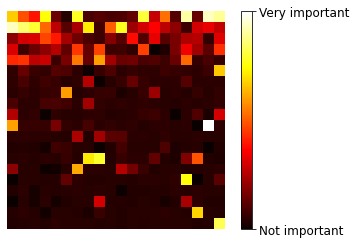

In [93]:
plot_digit(RF_clf.feature_importances_)

cbar = plt.colorbar(ticks=[RF_clf.feature_importances_.min(), RF_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

# Decison Tree Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
boost = GradientBoostingClassifier(n_estimators=500, learning_rate=0.005, random_state=2)
rdf_boost = boost.fit(X_train, y_train)
y_pred_boost = rdf_boost.predict(X_test)
CM_boost = confusion_matrix(y_test,y_pred_boost)

In [121]:
print(classification_report(y_test,y_pred_boost))

              precision    recall  f1-score   support

           1       0.94      0.97      0.95       460
           2       0.69      0.61      0.65       457
           3       0.70      0.74      0.72       457
           4       0.92      0.88      0.90       469
           5       0.81      0.86      0.83       457

    accuracy                           0.81      2300
   macro avg       0.81      0.81      0.81      2300
weighted avg       0.81      0.81      0.81      2300



In [ ]:
classification_report(CM_boost)

# Lastly, we do a voting CLF

In [50]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('SVM', SVM_clf), ('RF', RF_clf), ('Boost', boost)],
    voting='hard')

In [51]:
rdf_voting = voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('SVM', SVC(random_state=42)),
                             ('RF',
                              RandomForestClassifier(n_estimators=500,
                                                     random_state=2)),
                             ('Boost',
                              GradientBoostingClassifier(learning_rate=0.005,
                                                         n_estimators=500,
                                                         random_state=2))])

In [62]:
y_pred_voting = voting_clf.predict(X_test)
CM_voting = confusion_matrix(y_test,y_pred_voting)

In [122]:
print(classification_report(y_test,y_pred_voting))

              precision    recall  f1-score   support

           1       0.95      0.97      0.96       460
           2       0.72      0.71      0.71       457
           3       0.77      0.71      0.74       457
           4       0.93      0.87      0.90       469
           5       0.80      0.89      0.84       457

    accuracy                           0.83      2300
   macro avg       0.83      0.83      0.83      2300
weighted avg       0.83      0.83      0.83      2300

